In [24]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt  
import tensorflow as tf 
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras 
from sklearn.utils.class_weight import compute_class_weight


In [2]:
train_data = pd.read_csv('../data/fraudTest.csv')
test_data = pd.read_csv('../data/fraudTest.csv')

In [3]:
df = pd.concat([train_data, test_data], ignore_index=True)


In [5]:
df = df.drop('Unnamed: 0', axis=1)


In [6]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111438 entries, 0 to 1111437
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1111438 non-null  object 
 1   cc_num                 1111438 non-null  int64  
 2   merchant               1111438 non-null  object 
 3   category               1111438 non-null  object 
 4   amt                    1111438 non-null  float64
 5   first                  1111438 non-null  object 
 6   last                   1111438 non-null  object 
 7   gender                 1111438 non-null  object 
 8   street                 1111438 non-null  object 
 9   city                   1111438 non-null  object 
 10  state                  1111438 non-null  object 
 11  zip                    1111438 non-null  int64  
 12  lat                    1111438 non-null  float64
 13  long                   1111438 non-null  float64
 14  city_pop          

In [7]:
# Drop unnecessary columns (modify as needed)
df = df.drop(['trans_date_trans_time', 'first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'trans_num'], axis=1)


In [9]:
# Convert categorical variables to numerical representation
label_encoder = LabelEncoder()
categorical_columns = ['merchant', 'category', 'gender', 'job']
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])


In [10]:

# Normalize numerical features
scaler = StandardScaler()
numerical_columns = ['cc_num', 'amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [30]:
df

,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud
0,-0.317252,319,10,-0.424463,1,-0.904377,0.677451,0.816521,275,-1.703871,-0.894145,0.657586,0
1,-0.316273,591,10,-0.252337,0,0.351182,-1.472454,-0.292685,392,-1.703869,0.178126,-1.436610,0
2,-0.316254,611,5,-0.179353,0,0.420768,1.216667,-0.178853,259,-1.703865,0.383257,1.167640,0
3,-0.316259,222,9,-0.059605,1,-1.970539,0.685934,-0.111371,407,-1.703861,-1.909485,0.680717,0
4,-0.316308,292,13,-0.422358,1,1.128092,0.380004,-0.289942,196,-1.703861,1.259139,0.316510,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111433,-0.318978,507,5,-0.163467,1,0.385244,-0.120967,-0.291963,460,1.510350,0.275527,-0.080241,0
1111434,-0.316286,264,7,0.270803,1,-1.877757,-0.379599,-0.198018,198,1.510351,-1.742946,-0.433644,0
1111435,-0.314411,496,7,0.111564,0,1.512121,-2.089408,-0.281427,294,1.510352,1.592587,-2.146912,0
1111436,-0.318998,75,13,-0.391735,1,1.201709,-1.910685,-0.293261,58,1.510354,1.163252,-1.955100,0


In [12]:
def custom_train_test_val_split(df, train_ratio=0.7, test_ratio=0.15, val_ratio=0.15, seed=None):
    """
    Custom function to split a DataFrame into training, testing, and validation sets.

    Parameters:
    - df: pandas DataFrame
    - train_ratio: float, ratio of training data (default is 0.7)
    - test_ratio: float, ratio of testing data (default is 0.15)
    - val_ratio: float, ratio of validation data (default is 0.15)
    - seed: int, seed for random shuffling (optional)

    Returns:
    - train_df, test_df, val_df: pandas DataFrames
    """
    # Set seed for reproducibility
    if seed is not None:
        df = df.sample(frac=1, random_state=seed)
    else:
        df = df.sample(frac=1)  # Shuffle the DataFrame

    # Calculate split indices
    train_size = int(train_ratio * len(df))
    test_size = int(test_ratio * len(df))

    # Split the DataFrame
    train_df = df[:train_size]
    test_df = df[train_size:train_size + test_size]
    val_df = df[train_size + test_size:]

    return train_df, test_df, val_df

In [13]:
train_df, test_df, val_df = custom_train_test_val_split(df , 0.7, 0.15 , 0.15 , 444)

In [17]:
train_x = train_df.drop('is_fraud', axis=1)
train_y = train_df['is_fraud']
val__x = val_df.drop('is_fraud', axis=1)
val_y = val_df['is_fraud']
test_x = test_df.drop('is_fraud', axis=1)
test_y = test_df['is_fraud']


In [25]:
# Calculate class weights ; for the imbalanced problem 
class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_y)
class_weight_dict = dict(zip([0, 1], class_weights))

In [26]:
class_weight_dict

{0: 0.5019367641973461, 1: 129.58127914723516}

In [21]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(train_x.shape[1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Learning rate Sceduling 
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate= )

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [27]:
model.fit(train_x, train_y, epochs=10, batch_size=64, validation_data=(val__x, val_y), class_weight=class_weight_dict)


Epoch 1/10
12157/12157 [==============================] - 39s 3ms/step - loss: 0.9656 - accuracy: 0.7770 - val_loss: 0.1025 - val_accuracy: 0.9955
Epoch 2/10
12157/12157 [==============================] - 42s 3ms/step - loss: 0.6492 - accuracy: 0.8382 - val_loss: 0.4304 - val_accuracy: 0.9836
Epoch 3/10
12157/12157 [==============================] - 40s 3ms/step - loss: 0.5483 - accuracy: 0.9355 - val_loss: 0.4475 - val_accuracy: 0.9788
Epoch 4/10
12157/12157 [==============================] - 40s 3ms/step - loss: 0.5145 - accuracy: 0.9389 - val_loss: 0.4607 - val_accuracy: 0.9701
Epoch 5/10
12157/12157 [==============================] - 39s 3ms/step - loss: 0.5037 - accuracy: 0.9454 - val_loss: 0.4120 - val_accuracy: 0.9836
Epoch 6/10
12157/12157 [==============================] - 41s 3ms/step - loss: 0.5012 - accuracy: 0.9501 - val_loss: 0.3945 - val_accuracy: 0.9805
Epoch 7/10
12157/12157 [==============================] - 44s 4ms/step - loss: 0.4930 - accuracy: 0.9490 - val_loss: 0

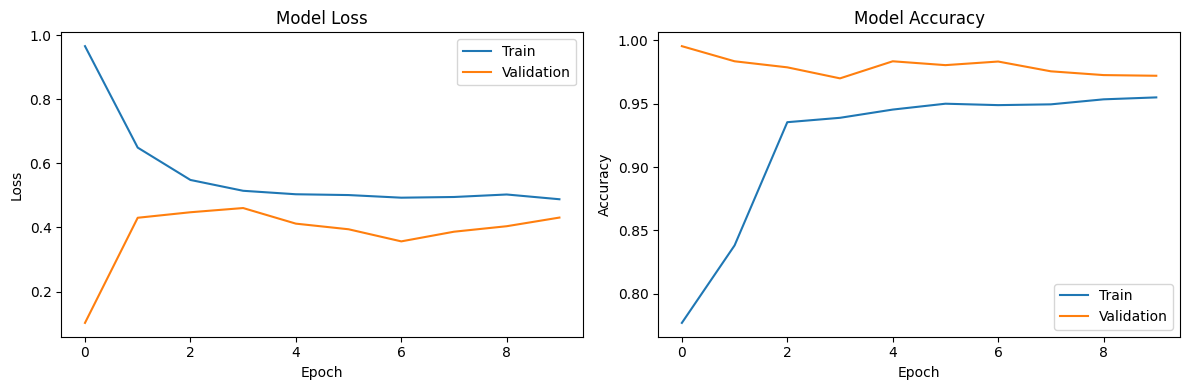

In [28]:

# Access the training history
history = model.history

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [29]:
model.save("../model/model.h5")

c:\Users\sapko\anaconda3\envs\cfdp\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
